Figure 1 of Wed Poly paper. Plot Temp, Salt, Rho (maybe 02, DIC) zonally averaged across Weddell Sea. Compare Wombat with and without neutral physics with WOCE and BGC obs estimates?

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
#from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
#import seawater as sw
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gsw as gsw
import cmocean as cm

Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

0.11.0


In [4]:
NP_CntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NP_CntrlDir,'Tdim_output197*/ocean__*.nc')
print Ocean_File
np_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print np_cntrl.temp.shape

NoNP_CntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NoNP_CntrlDir,'output197*/ocean__*.nc')
print Ocean_File
nonp_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print nonp_cntrl.temp.shape



/g/data/v45/pas561/mom/archive/wombat_jun16z/Tdim_output197*/ocean__*.nc
(9, 50, 1080, 1440)
/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/output197*/ocean__*.nc
(9, 50, 1080, 1440)


In [5]:
nc = Dataset('/g/data/v45/pas561/mom/archive/WOA/woa13_mom025_ocean_temp_salt.res.nc', mode='r') # file handle, open in read only mode
grid_xt = nc.variables['GRID_X_T'][:]
grid_yt = nc.variables['GRID_Y_T'][:]
zt = nc.variables['ZT'][:]
woa_temp = nc.variables['temp'][:]
woa_salt = nc.variables['salt'][:]
nc.close() # close the file

print woa_salt.shape, woa_temp.shape, grid_xt.shape, grid_yt.shape, zt.shape

woa_temp=np.squeeze(woa_temp)
woa_salt=np.squeeze(woa_salt)

print woa_salt.shape, woa_temp.shape


(1, 50, 1080, 1440) (1, 50, 1080, 1440) (1440,) (1080,) (50,)
(50, 1080, 1440) (50, 1080, 1440)


In [6]:
#calc WOA rho from T/S
#rho=sw.pden(30,30,100,0)
#print rho

#resize st_ocean to 50x1080x1440
#st_grid=np.tile(st_ocean,1080*1440).reshape(1440,1080,50)
#st_grid=np.transpose(st_grid)
#print st_grid.shape

#woa_rho0=sw.pden(woa_salt,woa_temp,st_grid,0)
#print woa_rho0[0:5,500,500]
    
of='/g/data/v45/pas561/mom/archive/WOA/woa13_mom025_ocean_temp_salt_to_rho0.npy'
#print of
#a=np.save(of,woa_rho0)
woa_rho=np.load(of)
print woa_rho.shape

(50, 1080, 1440)


In [7]:
#mask bathy 
msk=np_cntrl.temp[0].load()
print msk[:,500,500]
print woa_temp[:,500,500]


woa_temp[np.where(isnan(msk))]=nan
print woa_temp[:,500,500]
woa_salt[np.where(isnan(msk))]=nan
print woa_salt[:,500,500]
woa_rho[np.where(isnan(msk))]=nan
print woa_rho[:,500,500]


<xarray.DataArray 'temp' (st_ocean: 50)>
array([27.42457 , 27.403734, 27.367304, 27.31325 , 27.230392, 27.099178,
       26.885996, 26.607784, 25.946142, 24.84249 , 23.548683, 21.788708,
       19.614935, 17.0357  , 14.532685, 12.557178, 11.19963 , 10.167709,
        9.405543,  8.86235 ,  8.378262,  7.889383,  7.349973,  6.820796,
        6.328948,  5.805981,  5.194328,  4.543918,  3.917311,  3.368901,
        2.968703,  2.647794,  2.374471,  2.157863,  1.963835,  1.798335,
        1.668957,  1.546484,  1.44171 ,  1.379732,  1.321743,  1.272609,
        1.230481,  1.185575,  1.097728,  1.058901,  1.04375 ,       nan,
             nan,       nan], dtype=float32)
Coordinates:
    xt_ocean  float64 -154.9
    yt_ocean  float64 0.625
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_

In [8]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
#could also try -65 to get full Weddell Sea
x1=np.argwhere(grid_xt<-60) #-60
x2=np.argwhere(grid_xt<0)#was going to -15 but woa o2 data resets at 0
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-55)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]
print x1, x2, xt_ocean[x1],xt_ocean[x2], yt_ocean[y1]


[879] [1119] [-60.125] [-0.125] [-55.13874852]
[879] [1119] [-60.125] [-0.125] [-55.13874852]


In [9]:
print(x1.item(),x2.item())

(879, 1119)


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(50, 500)
(50, 500)


Text(0.5,0,'$kg/m^3$')

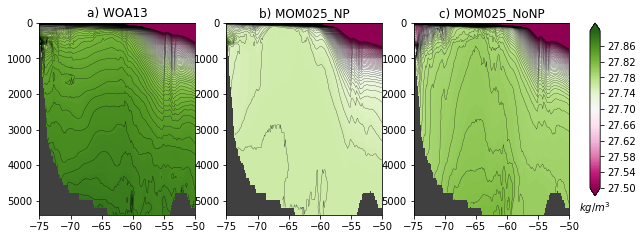

In [10]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

var1=np.nanmean(woa_rho[:,0:500,x1.item():x2.item()],axis=2)

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('a) WOA13')

yr=0

var1=np_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('b) MOM025_NP')

var1=nonp_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('c) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$kg/m^3$')




[-2.00000000e+00 -1.95000000e+00 -1.90000000e+00 -1.85000000e+00
 -1.80000000e+00 -1.75000000e+00 -1.70000000e+00 -1.65000000e+00
 -1.60000000e+00 -1.55000000e+00 -1.50000000e+00 -1.45000000e+00
 -1.40000000e+00 -1.35000000e+00 -1.30000000e+00 -1.25000000e+00
 -1.20000000e+00 -1.15000000e+00 -1.10000000e+00 -1.05000000e+00
 -1.00000000e+00 -9.50000000e-01 -9.00000000e-01 -8.50000000e-01
 -8.00000000e-01 -7.50000000e-01 -7.00000000e-01 -6.50000000e-01
 -6.00000000e-01 -5.50000000e-01 -5.00000000e-01 -4.50000000e-01
 -4.00000000e-01 -3.50000000e-01 -3.00000000e-01 -2.50000000e-01
 -2.00000000e-01 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02
  1.77635684e-15  5.00000000e-02  1.00000000e-01  1.50000000e-01
  2.00000000e-01  2.50000000e-01  3.00000000e-01  3.50000000e-01
  4.00000000e-01  4.50000000e-01  5.00000000e-01  5.50000000e-01
  6.00000000e-01  6.50000000e-01  7.00000000e-01  7.50000000e-01
  8.00000000e-01  8.50000000e-01  9.00000000e-01  9.50000000e-01
  1.00000000e+00  1.05000

/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


(50, 500)
(50, 500)


Text(0.5,0,'$^\\circ C$')

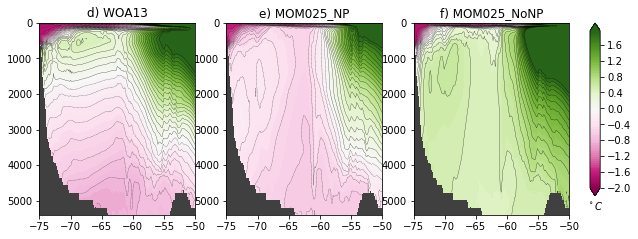

In [11]:
clev = np.arange(-2,2,.05)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
print clev3

var1=np.nanmean(woa_temp[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('d) WOA13')

yr=0

var1=np_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('e) MOM025_NP')

var1=nonp_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('f) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ C$')



[34.   34.01 34.02 34.03 34.04 34.05 34.06 34.07 34.08 34.09 34.1  34.11
 34.12 34.13 34.14 34.15 34.16 34.17 34.18 34.19 34.2  34.21 34.22 34.23
 34.24 34.25 34.26 34.27 34.28 34.29 34.3  34.31 34.32 34.33 34.34 34.35
 34.36 34.37 34.38 34.39 34.4  34.41 34.42 34.43 34.44 34.45 34.46 34.47
 34.48 34.49 34.5  34.51 34.52 34.53 34.54 34.55 34.56 34.57 34.58 34.59
 34.6  34.61 34.62 34.63 34.64 34.65 34.66 34.67 34.68 34.69 34.7  34.71
 34.72 34.73 34.74 34.75 34.76 34.77 34.78 34.79]
[34.   34.02 34.04 34.06 34.08 34.1  34.12 34.14 34.16 34.18 34.2  34.22
 34.24 34.26 34.28 34.3  34.32 34.34 34.36 34.38 34.4  34.42 34.44 34.46
 34.48 34.5  34.52 34.54 34.56 34.58 34.6  34.62 34.64 34.66 34.68 34.7
 34.72 34.74 34.76 34.78]


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


(50, 500)
(50, 500)


Text(0.5,0,'$S_A$')

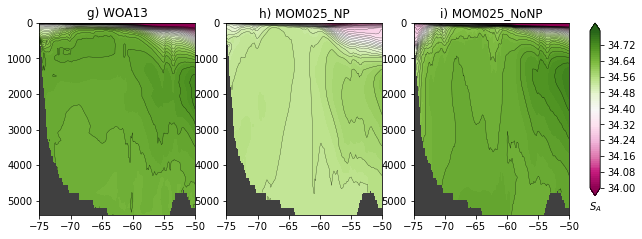

In [12]:
clev = np.arange(34,34.8,.01)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
print clev3

var1=np.nanmean(woa_salt[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA13')

yr=0

var1=np_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$S_A$')




/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


(50, 500)
(50, 500)


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice


(50, 500)
(50, 500)


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: Mean of empty slice


(50, 500)
(50, 500)


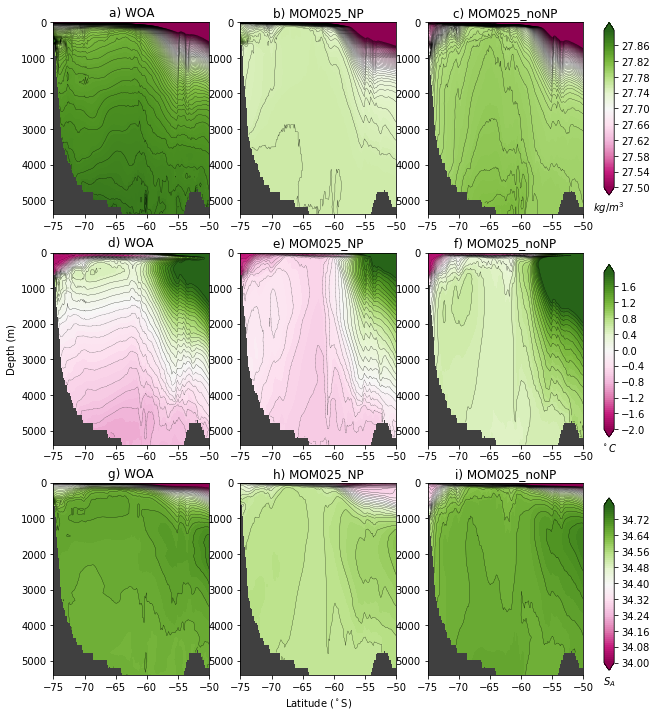

In [13]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')
var1=np.nanmean(woa_rho[:,0:500,x1.item():x2.item()],axis=2)

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('a) WOA')

yr=0

var1=np_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('b) MOM025_NP')

var1=nonp_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('c) MOM025_noNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$kg/m^3$')


clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

var1=np.nanmean(woa_temp[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(3,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('d) WOA')

yr=0

var1=np_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('e) MOM025_NP')

var1=nonp_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('f) MOM025_noNP')

ax3 = plt.axes([0.93,0.40,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3

var1=np.nanmean(woa_salt[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(3,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA')

yr=0

var1=np_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_noNP')

ax3 = plt.axes([0.93,0.13,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)

of = '/g/data/v45/pas561/mom/archive/wp2_figs/TS_WOCE.png'
plt.savefig(of,dpi=220)



In [14]:
#do oxygen and dic comparison to obs

#model is in units of mmol/m^3 for 02

NP_CntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NP_CntrlDir,'Tdim_output197*/ocean_bgc_carbon*.nc')
print Ocean_File
np_cntrl_bgc=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print np_cntrl_bgc.o2.shape

NoNP_CntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NoNP_CntrlDir,'output197*/ocean_bgc_carbon*.nc')
print Ocean_File
nonp_cntrl_bgc=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print nonp_cntrl_bgc.o2.shape


/g/data/v45/pas561/mom/archive/wombat_jun16z/Tdim_output197*/ocean_bgc_carbon*.nc
(108, 50, 1080, 1440)
/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/output197*/ocean_bgc_carbon*.nc
(96, 50, 1080, 1440)


In [15]:

#model is in units of mmol/m^3

#this seems like old WOA obs. Units are umols -> 1000 umol= mmol
nc = Dataset('/g/data/v45/pas561/mom/archive/bgc_obs/Oxy.nc', mode='r') # file handle, open in read only mode
##lon goes from 0-360
woa1_lon = nc.variables['lon'][:]
woa1_lat = nc.variables['lat'][:]
woa1_depth = nc.variables['depth'][:]
woa1_oxy = nc.variables['Oxy'][:]
nc.close() # close the file

print woa1_oxy.shape
#print lat
#print lon

#this is the 2013v2 woa data from https://www.nodc.noaa.gov/OC5/woa13/woa13data.html
#units are ml/l
nc = Dataset('/g/data/v45/pas561/mom/archive/bgc_obs/woa13_all_o00_01.nc', mode='r') # file handle, open in read only mode
#note lon goes from -180 to 180
woa2_lon = nc.variables['lon'][:]
woa2_lat = nc.variables['lat'][:]
woa2_depth = nc.variables['depth'][:]
woa2_oxy = nc.variables['o_an'][:]
nc.close() # close the file

print woa2_oxy.shape

print woa1_lat
print woa2_lat

#model data is in mmol/m3
#convert everything to umol/kg to match CCHDO data

#convert  ml/l to mmol/m3
#1 μmol O2 = .022391 ml
#1 ml/l = 103/22.391 = 44.661 μmol/l

#ml/L/44.661= μmol/L*1000L/m3=umol/m3/1000=mmol/m3
woa2_oxy=woa2_oxy*44.661


(33, 180, 360)
(1, 102, 180, 360)
[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5
 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5
 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5
  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5
   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5
  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5
  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5
  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5
  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5
  66.5  67.5  68.

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/numpy/ma/core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [16]:
nc = Dataset('/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra111to120.nc', mode='r') # file handle, open in read only mode
dzt = nc.variables['dzt'][0,:,:,:]
nc.close() # close the file
print dzt.shape

#this seems like old WOA obs. Units are micro mols -> 1000 umol= mmol
#need to convert model data in mmol/m3 to umol

dvt=dzt*area_t

print dvt.shape
vol=np.ma.sum(dvt)
print vol

#google says volume of ocean is 1.3 billion km3
gvol=1300000000*1000*1000*1000
print gvol/1E18
print gvol-vol

#np_O2=np_cntrl_bgc.o2[0:12,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
#convert mmol/m3 to umol = *dvt/1000
np_O2=np_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('time').load()#*dvt[:,0:500,x1:x2]/1000
print np_O2.shape

nonp_O2=nonp_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('Time').load()#*dvt[:,0:500,x1:x2]/1000
print nonp_O2.shape


(50, 1080, 1440)
(50, 1080, 1440)
1.3064032e+18
1.3
-6403157361819648.0
(50, 500, 240)
(50, 500, 240)


In [17]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
#could also try -65 to get full Weddell Sea
woa1_x1=np.argwhere(woa1_lon<300)
woa1_x2=np.argwhere(woa1_lon<360)
woa1_x1=woa1_x1[-1]
woa1_x2=woa1_x2[-1]

woa2_x1=np.argwhere(woa2_lon<-60)
woa2_x2=np.argwhere(woa2_lon<0)
woa2_x1=woa2_x1[-1]
woa2_x2=woa2_x2[-1]

woa_y1=np.argwhere(woa1_lat<-65)
#y2=np.argwhere(xt_ocean<15)
woa_y1=woa_y1[-1]
#y2=y2[-1]

#print 'woa1: ', woa1_x1, woa1_x2, woa1_lon[woa1_x1],woa1_lon[woa1_x2], woa1_lat[woa_y1]

print woa2_oxy.shape
print 'woa2: ', woa2_x1, woa2_x2, woa_y1, woa2_lon[woa2_x1],woa2_lon[woa2_x2], woa2_lat[woa_y1]

#print woa1_oxy[:,30,100]
print woa2_oxy[:,woa_y1,woa2_x1]



(1, 102, 180, 360)
woa2:  [119] [179] [24] [-60.5] [-0.5] [-65.5]
[[[219.01914978027344 218.3555450439453 217.8384552001953
   217.8188018798828 218.53199768066406 219.64608764648438
   220.84197998046875 221.5035858154297 221.70375061035156
   221.75283813476562 222.05282592773438 222.7701873779297 223.14453125
   223.2859344482422 223.08387756347656 222.57989501953125
   222.12014770507812 222.0335235595703 222.1275634765625
   222.482177734375 222.83058166503906 223.0753631591797
   223.27601623535156 223.41571044921875 223.44735717773438
   223.47109985351562 223.5016632080078 223.59922790527344
   223.81344604492188 224.0856170654297 224.41485595703125
   224.76239013671875 225.26426696777344 225.5645294189453
   225.49716186523438 224.75631713867188 223.55856323242188
   222.31715393066406 221.38958740234375 220.9082794189453
   220.83433532714844 221.0756378173828 221.4679412841797
   221.70269775390625 221.569580078125 221.19155883789062
   220.75982666015625 220.34274291992188

[150.  150.1 150.2 ... 349.7 349.8 349.9]
[150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320
 330 340]
(50, 500)
(50, 500)


Text(0.5,0,'$mmol/m^3$')

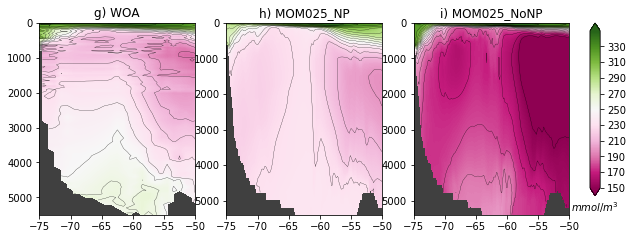

In [18]:
#Weddell Sea 60W-0E

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(150,350,.1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(150,350,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.nanmean(woa2_oxy[0,:,0:90,woa2_x1.item():woa2_x2.item()],axis=2)
#print var1.shape

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA')

yr=0

var1=np_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
#var1=np.nanmean(np_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
#var1=np.nanmean(nonp_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$mmol/m^3$')




0.975609756098
[150.  150.1 150.2 ... 349.7 349.8 349.9]
[150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320
 330 340]
(50, 500)
(50, 500)


Text(0.5,0,'$\\mu mol/kg$')

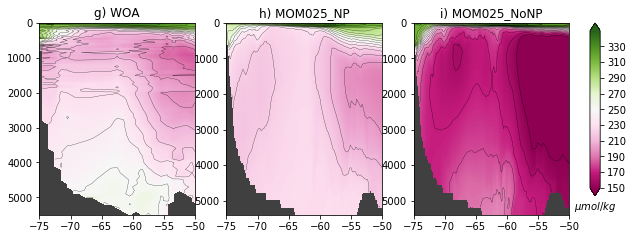

In [19]:
#plot Weddell values in umol/kg: *10^3/1025kg/m3
const=1000.0/1025
print const

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(150,350,.1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(150,350,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.nanmean(woa2_oxy[0,:,0:90,woa2_x1.item():woa2_x2.item()],axis=2)*const
#print var1.shape

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA')

yr=0

var1=np_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()*const
#var1=np.nanmean(np_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()*const
#var1=np.nanmean(nonp_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$\mu mol/kg$')

(1, 102, 180, 360)
woa2:  [112] [199] [54] [-67.5] [19.5] [-35.5]
[851] [1199] [-67.125] [19.875] [-35.18026735]
0.975609756098
[150.  150.1 150.2 ... 349.7 349.8 349.9]
[150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320
 330 340]
(50, 500)
(50, 500)


Text(0.5,0,'$\\mu mol/kg$')

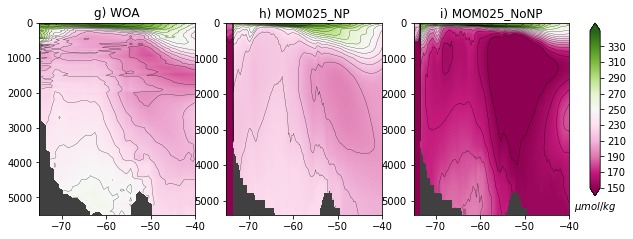

In [20]:
#plot Atlantic Basin values in umol/kg: *10^3/1025kg/m3
woa2_x1=np.argwhere(woa2_lon<-67)
woa2_x2=np.argwhere(woa2_lon<20)
woa2_x1=woa2_x1[-1]
woa2_x2=woa2_x2[-1]

woa_y1=np.argwhere(woa1_lat<-35)
#y2=np.argwhere(xt_ocean<15)
woa_y1=woa_y1[-1]
#y2=y2[-1]
#print 'woa1: ', woa1_x1, woa1_x2, woa1_lon[woa1_x1],woa1_lon[woa1_x2], woa1_lat[woa_y1]
print woa2_oxy.shape
print 'woa2: ', woa2_x1, woa2_x2, woa_y1, woa2_lon[woa2_x1],woa2_lon[woa2_x2], woa2_lat[woa_y1]

x1=np.argwhere(grid_xt<-67)
x2=np.argwhere(grid_xt<20)#was going to -15 but woa o2 data resets at 0
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-35)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]


const=1000.0/1025
print const

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(150,350,.1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(150,350,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.nanmean(woa2_oxy[0,:,0:90,woa2_x1.item():woa2_x2.item()],axis=2)*const
#print var1.shape

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-40])
plt.title('g) WOA')

yr=0

var1=np_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()*const
#var1=np.nanmean(np_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-40])
plt.title('h) MOM025_NP')

var1=nonp_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()*const
#var1=np.nanmean(nonp_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-40])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$\mu mol/kg$')

(1, 102, 180, 360)
woa2:  [112] [199] [34] [-67.5] [19.5] [-55.5] [-50.5]
[819] [1199] [-75.125] [19.875] [-55.13874852]
0.975609756098
[150.  150.1 150.2 ... 349.7 349.8 349.9]
[150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320
 330 340]
(50, 1440)
(50, 1440)


Text(0.5,0,'$umol/kg$')

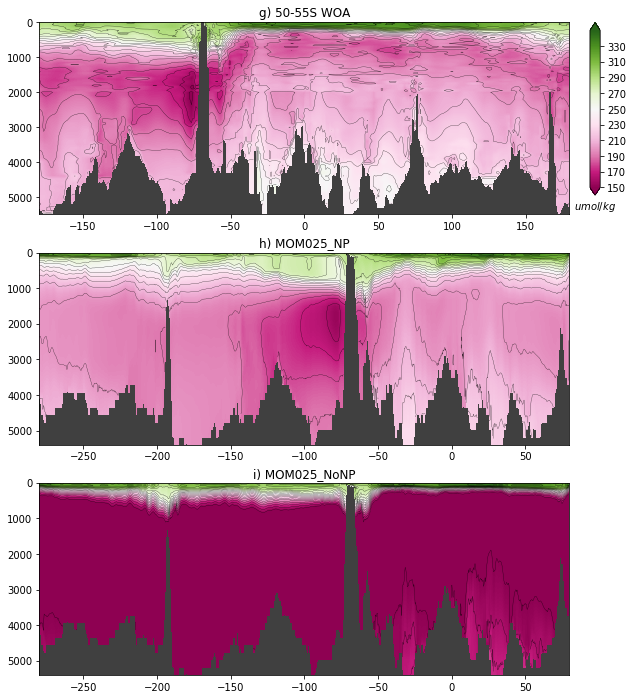

In [21]:
#plot Atlantic dep lat slices at 60S and 50S 
#Basin values in umol/kg: *10^3/1025kg/m3

woa2_x1=np.argwhere(woa2_lon<-67)
woa2_x2=np.argwhere(woa2_lon<20)
woa2_x1=woa2_x1[-1]
woa2_x2=woa2_x2[-1]

woa_y1=np.argwhere(woa1_lat<-55)
#y2=np.argwhere(xt_ocean<15)
woa_y1=woa_y1[-1]

woa_y2=np.argwhere(woa1_lat<-50)
woa_y2=woa_y2[-1]

#y2=y2[-1]
#print 'woa1: ', woa1_x1, woa1_x2, woa1_lon[woa1_x1],woa1_lon[woa1_x2], woa1_lat[woa_y1]
print woa2_oxy.shape
print 'woa2: ', woa2_x1, woa2_x2, woa_y1, woa2_lon[woa2_x1],woa2_lon[woa2_x2], woa2_lat[woa_y1], woa2_lat[woa_y2]

x1=np.argwhere(grid_xt<-75)
x2=np.argwhere(grid_xt<20)#was going to -15 but woa o2 data resets at 0
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-55)
y1=y1[-1]
y2=np.argwhere(grid_yt<-50)
y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]


const=1000.0/1025
print const

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(150,350,.1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(150,350,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.nanmean(woa2_oxy[0,:,woa_y1.item():woa_y2.item(),:],axis=1)*const
#print var1.shape

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lon,woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lon,woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
#plt.xlim([-75,-40])
plt.title('g) 50-55S WOA')

yr=0

var1=np_cntrl_bgc.o2[0:12,:,y1.item():y2.item(),:].mean('time').mean('yt_ocean').load()*const
#var1=np.nanmean(np_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(xt_ocean,st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
#plt.xlim([-75,-40])
plt.title('h) MOM025_NP')

var1=nonp_cntrl_bgc.o2[0:12,:,y1.item():y2.item(),:].mean('Time').mean('yt_ocean').load()*const
#var1=np.nanmean(nonp_O2[:,0:500,x1:x2],axis=2)
print var1.shape

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(xt_ocean,st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
#plt.xlim([-75,-40])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$umol/kg$')

/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


(50, 500)
(50, 500)


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice


(50, 500)
(50, 500)


/g/data/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice


(50, 500)
(50, 500)
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349]
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290]
(102, 90)
(50, 500)
(50, 500)


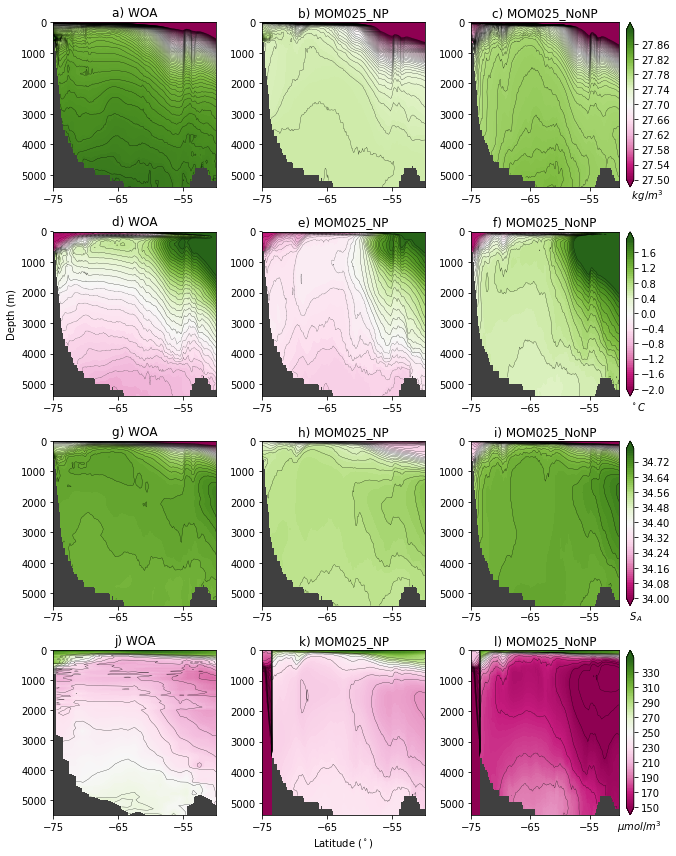

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plot control zavg temp, rho, salt -60W to 0W
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')
var1=np.nanmean(woa_rho[:,0:500,x1.item():x2.item()],axis=2)

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(4,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('a) WOA')

yr=0

var1=np_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('b) MOM025_NP')

var1=nonp_cntrl.pot_rho_0[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('c) MOM025_NoNP')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('           $kg/m^3$',labelpad=0)

clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

var1=np.nanmean(woa_temp[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(4,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('d) WOA')

yr=0

var1=np_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('e) MOM025_NP')

var1=nonp_cntrl.temp[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('f) MOM025_NoNP')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('     $^\circ C$')

clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3

var1=np.nanmean(woa_salt[:,0:500,x1.item():x2.item()],axis=2)

plt.subplot(4,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('g) WOA')

yr=0

var1=np_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('h) MOM025_NP')

var1=nonp_cntrl.salt[0:9,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('i) MOM025_NoNP')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('    $S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)


clev = np.arange(150,350,1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(0,300,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.nanmean(woa2_oxy[0,:,0:90,woa2_x1.item():woa2_x2.item()],axis=2)
print var1.shape

plt.subplot(4,3,10)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('j) WOA')

yr=0

var1=np_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,11)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('k) MOM025_NP')

var1=nonp_cntrl_bgc.o2[0:12,:,0:500,x1.item():x2.item()].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(4,3,12)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.xticks([-75,-65,-55])
plt.title('l) MOM025_NoNP')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('      $\mu mol/m^3$')

plt.tight_layout()
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/TS_02_WOA.png'
#of = '/g/data1/v45/pas561/mom/archive/wp2_figs/test.png'
plt.savefig(of,dpi=220)


[819] [1199] [-75.125] [19.875] [-55.13874852]
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349]
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 1

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


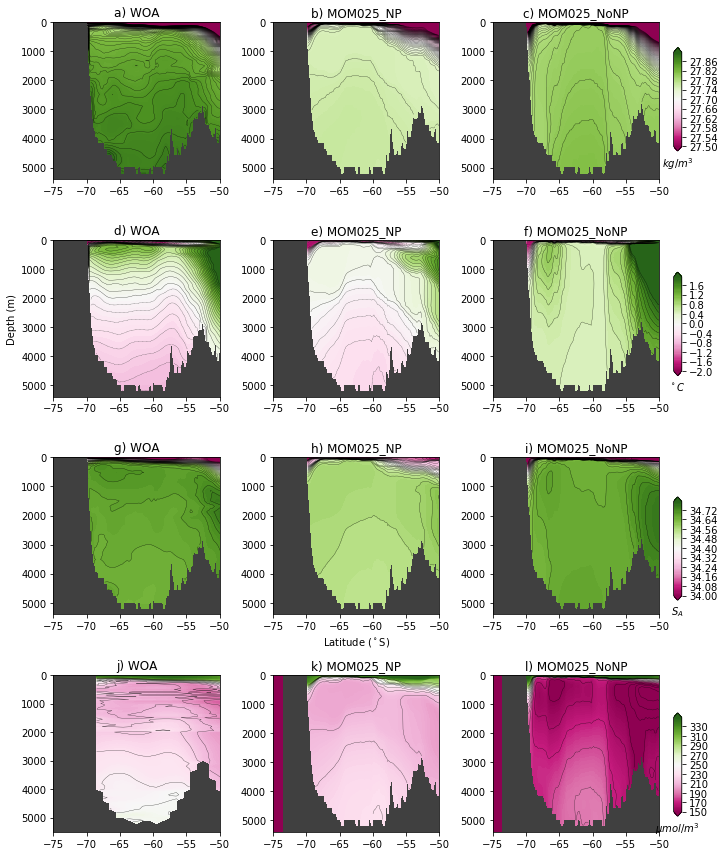

In [23]:
#plot control temp, rho, salt at 0W
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

#var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)
var1= np.squeeze(woa_rho[:,0:500,x2])
print var1.shape

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(4,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('a) WOA')

yr=0

var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('b) MOM025_NP')

var1=np.squeeze(nonp_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('c) MOM025_NoNP')

ax3 = plt.axes([0.99,0.82,0.012,0.12])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$kg/m^3$')


clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

var1=np.squeeze(woa_temp[:,0:500,x2])

plt.subplot(4,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('d) WOA')

yr=0

var1=np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('e) MOM025_NP')

var1=np.squeeze(nonp_cntrl.temp[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('f) MOM025_NoNP')

ax3 = plt.axes([0.99,0.56,0.012,0.12])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3

var1=np.squeeze(woa_salt[:,0:500,x2])

plt.subplot(4,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA')

yr=0

var1=np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=np.squeeze(nonp_cntrl.salt[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.99,0.30,0.012,0.12])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)


clev = np.arange(150,350,1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(0,300,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.squeeze(woa2_oxy[0,:,0:90,woa2_x2])
print var1.shape

plt.subplot(4,3,10)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('j) WOA')

yr=0

var1=np.squeeze(np_cntrl_bgc.o2[0:12,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,11)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('k) MOM025_NP')

var1=np.squeeze(nonp_cntrl_bgc.o2[0:12,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,3,12)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('l) MOM025_NoNP')

ax3 = plt.axes([0.99,0.05,0.012,0.12])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$\mu mol/m^3$')

plt.tight_layout()

of = '/g/data/v45/pas561/mom/archive/wp2_figs/TS_02_WOA_0W.png'
plt.savefig(of,dpi=220)



In [24]:
#Evaluate MOM01
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/'
Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean.nc')
print Ocean_File
mom01_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print mom01_cntrl.temp.shape



/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/output*/ocean.nc
(149, 75, 2700, 3600)


In [25]:
mom01_cntrl

<xarray.Dataset>
Dimensions:          (grid_xt_ocean: 3600, grid_yu_ocean: 2700, nv: 2, potrho: 80, potrho_edges: 81, st_edges_ocean: 76, st_ocean: 75, sw_edges_ocean: 76, sw_ocean: 75, time: 149, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean         (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean         (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * nv               (nv) float64 1.0 2.0
  * xu_ocean         (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean         (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean         (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * st_edges_ocean   (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * sw_ocean         (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 0.5128 1.652 ... 5.809e+03
  * grid_xt_ocean    (grid_xt_ocean) float64 -279.9 -279.8 

In [26]:
mom01_xt_ocean = mom01_cntrl.variables['xt_ocean'][:].load()
mom01_xt_ocean

<xarray.IndexVariable u'xt_ocean' (xt_ocean: 3600)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X

In [27]:
vgrid_file ='/g/data3/hh5/tmp/pas561/kds75_cp/output430/ocean.nc'
nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
mom01_st_ocean = nc.variables['st_ocean'][:]
mom01_yt_ocean = nc.variables['yt_ocean'][:]
mom01_xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the 
print mom01_xt_ocean.shape
print mom01_st_ocean.shape

mom01_x1=np.argwhere(mom01_xt_ocean<-60) #-60
mom01_x2=np.argwhere(mom01_xt_ocean<0)#was going to -15 but woa o2 data resets at 0
mom01_x1=mom01_x1[-1]
mom01_x2=mom01_x2[-1]

mom01_y1=np.argwhere(mom01_yt_ocean<-55)
#y2=np.argwhere(xt_ocean<15)
mom01_y1=mom01_y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]
print mom01_x1, mom01_x2, mom01_xt_ocean[mom01_x1],mom01_xt_ocean[mom01_x2], mom01_yt_ocean[mom01_y1]

(3600,)
(75,)
[819] [1199] [-75.125] [19.875] [-55.13874852]
[2199] [2799] [-60.05] [-0.05] [-55.00989048]


Text(0.5,1,'b) MOM01_noNP')

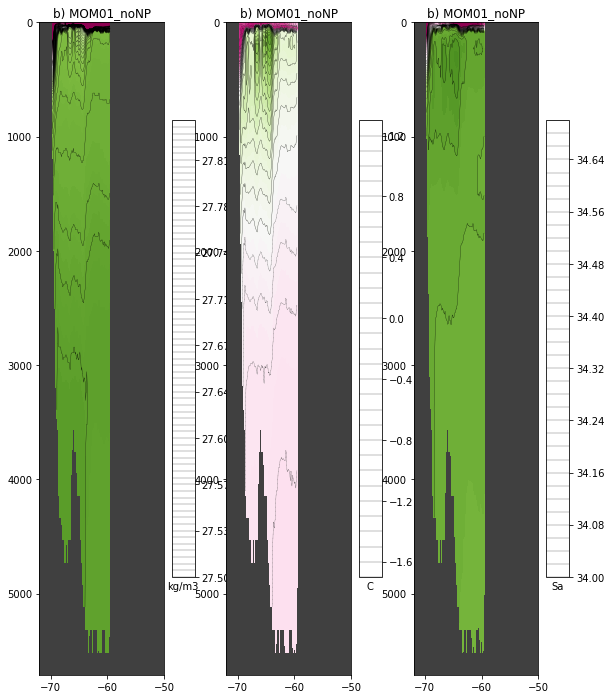

In [28]:
t1=3
t2=7
var1=np.squeeze(mom01_cntrl.pot_rho_0[t1:t2,:,0:500,mom01_x2].mean('time').load())

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(1,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:500],mom01_st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:500],mom01_st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.title('b) MOM01_noNP')

var1=np.squeeze(mom01_cntrl.temp[t1:t2,:,0:500,mom01_x2].mean('time').load())

clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

plt.subplot(1,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:500],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:500],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.title('b) MOM01_noNP')

var1=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:500,mom01_x2].mean('time').load())

clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3


plt.subplot(1,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:500],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:500],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.title('b) MOM01_noNP')



[819] [1199] [-75.125] [19.875] [-55.13874852]
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
(50, 500)
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349]
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 1

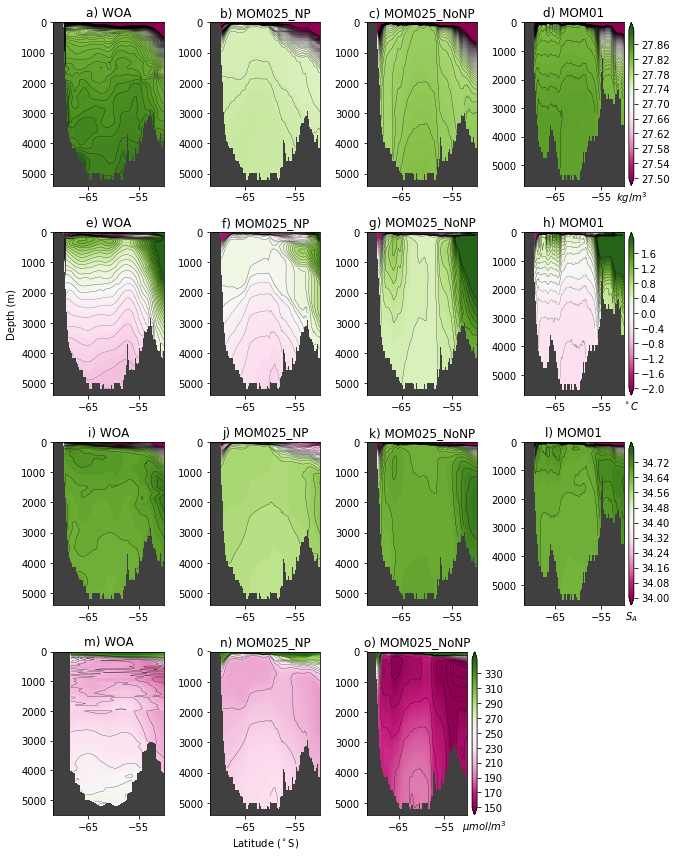

In [29]:
#plot control temp, rho, salt at 0W
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

#var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)
var1= np.squeeze(woa_rho[:,0:500,x2])
print var1.shape

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(4,4,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('a) WOA')

yr=0

var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,4,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('b) MOM025_NP')

var1=np.squeeze(nonp_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,4,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('c) MOM025_NoNP')


t1=3
t2=7
var1=np.squeeze(mom01_cntrl.pot_rho_0[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,4,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('d) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$kg/m^3$')


clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

var1=np.squeeze(woa_temp[:,0:500,x2])

plt.subplot(4,4,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('e) WOA')

yr=0

var1=np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,4,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('f) MOM025_NP')

var1=np.squeeze(nonp_cntrl.temp[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,4,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('g) MOM025_NoNP')



t1=3
t2=7
var1=np.squeeze(mom01_cntrl.temp[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,4,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('h) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3

var1=np.squeeze(woa_salt[:,0:500,x2])

plt.subplot(4,4,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('i) WOA')

yr=0

var1=np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,4,10)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('j) MOM025_NP')

var1=np.squeeze(nonp_cntrl.salt[0:9,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,4,11)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('k) MOM025_NoNP')


t1=3
t2=7
var1=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,4,12)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('l) MOM01')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)


clev = np.arange(150,350,1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(0,300,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.squeeze(woa2_oxy[0,:,0:90,woa2_x2])
print var1.shape

plt.subplot(4,4,13)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('m) WOA')

yr=0

var1=np.squeeze(np_cntrl_bgc.o2[0:12,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,4,14)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$S)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('n) MOM025_NP')

var1=np.squeeze(nonp_cntrl_bgc.o2[0:12,:,0:500,x2].mean('Time').load())
print var1.shape

plt.subplot(4,4,15)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('o) MOM025_NoNP')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('      $\mu mol/m^3$')

plt.tight_layout()

of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig1_TS_02_WOA_0W_all.png'
plt.savefig(of,dpi=220)



In [30]:
#convert rho and temp to sigma 2 and pot_rho 2
woa_rho2=gsw.sigma2(np.squeeze(woa_salt[:,0:500,x2]),np.squeeze(woa_temp[:,0:500,x2]))
woa_rho2.shape

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/gsw/gibbs/density_enthalpy_48.py:814: RuntimeWarning: invalid value encountered in maximum
  SA = np.maximum(SA, 0)


(50, 500)

In [31]:
#defs from https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.2013.0041
wsdw_salt=34.660
wsdw_temp=-0.380

wsbw_temp=-0.770
wsbw_salt=34.648

wsbw_rho2=gsw.sigma2(wsbw_salt,wsbw_temp)
wsdw_rho2=gsw.sigma2(wsdw_salt,wsdw_temp)
print wsbw_rho2, wsdw_rho2 

37.09624939476839 37.06460377298208


In [32]:
var1=np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())
var2=np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())

np_cntrl_rho2=gsw.sigma2(var1,var2)
np_cntrl_rho2.shape

(50, 500)

In [33]:
np_cntrl_temp=np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())
np_cntrl_salt=np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())

In [34]:
t1=3
t2=7
var1=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())
var2=np.squeeze(mom01_cntrl.temp[t1:t2,:,0:1000,mom01_x2].mean('time').load())

mom01_cntrl_rho2=gsw.sigma2(var1,var2)
mom01_cntrl_rho2.shape

(75, 1000)

In [35]:
mom01_cntrl_temp=np.squeeze(mom01_cntrl.temp[t1:t2,:,0:1000,mom01_x2].mean('time').load())
mom01_cntrl_salt=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())

In [36]:
mom01_st_ocean[43]

766.0667992097763

In [37]:
tick_lvls = np.arange(36.7, 37.3, .05)
tick_lvls

array([36.7 , 36.75, 36.8 , 36.85, 36.9 , 36.95, 37.  , 37.05, 37.1 ,
       37.15, 37.2 , 37.25])

[819] [1199] [-75.125] [19.875] [-55.13874852]
(25, 500)
(25, 500)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0,'$kg/m^3$')

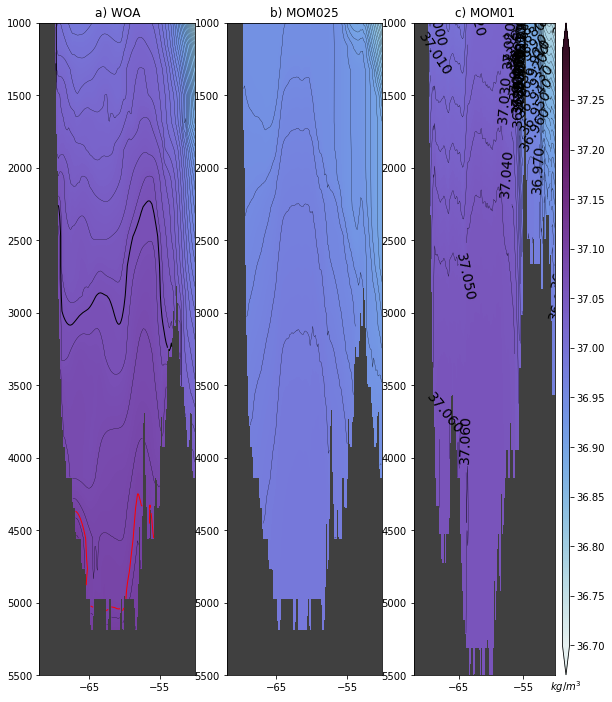

In [38]:
#plot control temp, rho, salt at 0W
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

#var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)
var1= woa_rho2[25:,0:500]
print var1.shape

clev = np.arange(36.7,37.3,.002)
tick_lvls = np.arange(36.7, 37.3, .05)
#tick_lvls
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(36.7,37.3,.01)
#print clev3

plt.subplot(1,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt[25:],var1,cmap=cm.cm.dense,levels=clev,extend='both') #
plt.contour(grid_yt[0:500],zt[25:],var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(grid_yt[0:500],zt[25:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(grid_yt[0:500],zt[25:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('a) WOA')

yr=0

#var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
var1=np_cntrl_rho2[25:,0:500]

print var1.shape

plt.subplot(1,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean[25:],var1,cmap=cm.cm.dense,levels=clev,extend='both') #,levels=clev
plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('b) MOM025')

#var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
var1=mom01_cntrl_rho2[43:,0:1000]

plt.subplot(1,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,cmap=cm.cm.dense,levels=clev,extend='both')
pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=clev3,colors='k',linewidths=0.25)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)

plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

plt.gca().invert_yaxis()
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('c) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical',ticks=tick_lvls)
cb.ax.set_xlabel('$kg/m^3$')


[819] [1199] [-75.125] [19.875] [-55.13874852]
(25, 500)
(25, 500)
(50, 500)
(50, 500)
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270]
[180 190 200 210 220 230 240 250 260 270]
(102, 90)
(50, 500)


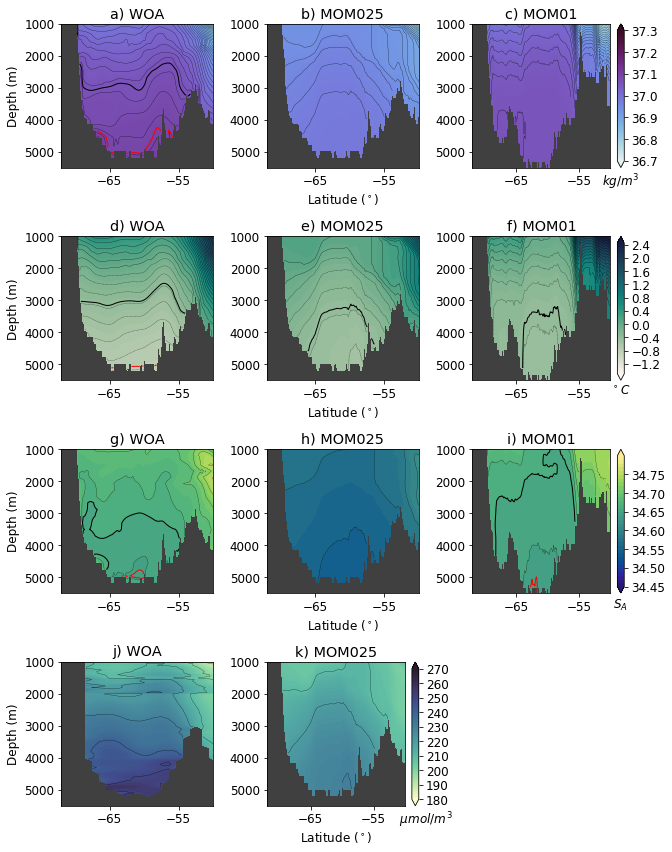

In [47]:
#plot control temp, rho, salt at 0W
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]

plt.rcParams['font.size'] = 12

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

#var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)
var1= woa_rho2[25:,0:500]
print var1.shape

clev = np.arange(36.7,37.302,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(36.7,37.31,.01)
tick_lvls = np.arange(36.7, 37.4, .1)
#print clev3

plt.subplot(4,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt[25:],var1,cmap=cm.cm.dense,levels=clev,extend='both') #
plt.contour(grid_yt[0:500],zt[25:],var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(grid_yt[0:500],zt[25:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(grid_yt[0:500],zt[25:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('a) WOA')

yr=0

#var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
var1=np_cntrl_rho2[25:,0:500]

print var1.shape

plt.subplot(4,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean[25:],var1,cmap=cm.cm.dense,levels=clev,extend='both') #,levels=clev
plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(yt_ocean[0:500],st_ocean[25:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('b) MOM025')

#var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
var1=mom01_cntrl_rho2[43:,0:1000]

plt.subplot(4,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,cmap=cm.cm.dense,levels=clev,extend='both')
pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=clev3,colors='k',linewidths=0.25)
#plt.clabel(pr, pr.levels, inline=True,fontsize=14)

plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=[wsdw_rho2],linestyles='solid',colors='k',linewidths=1.0)
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean[43:],var1,levels=[wsbw_rho2],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('c) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical',ticks=tick_lvls)
cb.ax.set_xlabel('$kg/m^3$')

clev = np.arange(-1.5,2.5,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-1.5,2.5,.1)
#print clev3

var1=np.squeeze(woa_temp[:,0:500,x2])

plt.subplot(4,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=cm.cm.tempo,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],zt,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(grid_yt[0:500],zt,var1,levels=[wsdw_temp],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(grid_yt[0:500],zt,var1,levels=[wsbw_temp],linestyles='solid',colors='r',linewidths=1.0)
#plt.clabel(pr, pr.levels, inline=True,fontsize=14)

plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('d) WOA')

yr=0

var1=np_cntrl_temp #np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=cm.cm.tempo,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(yt_ocean[0:500],st_ocean,var1,levels=[wsdw_temp],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(yt_ocean[0:500],st_ocean,var1,levels=[wsbw_temp],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('e) MOM025')

t1=3
t2=7
var1=mom01_cntrl_temp #np.squeeze(mom01_cntrl.temp[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=cm.cm.tempo,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsdw_temp],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsbw_temp],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('f) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34.45,34.81,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34.45,34.82,.02)
tick_lvls = np.arange(34.4, 34.8, .05)
#print clev3

var1=np.squeeze(woa_salt[:,0:500,x2])

plt.subplot(4,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=cm.cm.haline,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],zt,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(grid_yt[0:500],zt,var1,levels=[wsdw_salt],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(grid_yt[0:500],zt,var1,levels=[wsbw_salt],linestyles='solid',colors='r',linewidths=1.0)
#plt.clabel(pr, pr.levels, inline=True,fontsize=14)

plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('g) WOA')

yr=0

var1=np_cntrl_salt #np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=cm.cm.haline,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(yt_ocean[0:500],st_ocean,var1,levels=[wsdw_salt],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(yt_ocean[0:500],st_ocean,var1,levels=[wsbw_salt],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('h) MOM025')

t1=3
t2=7
var1=mom01_cntrl_salt #np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=cm.cm.haline,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsdw_salt],linestyles='solid',colors='k',linewidths=1.0)
pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsbw_salt],linestyles='solid',colors='r',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('i) MOM01')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical',ticks=tick_lvls)
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)


clev = np.arange(180,271,1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(180,280,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.squeeze(woa2_oxy[0,:,0:90,woa2_x2])
print var1.shape

plt.subplot(4,3,10)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=cm.cm.deep,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('j) WOA')

yr=0

var1=np.squeeze(np_cntrl_bgc.o2[0:12,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,11)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=cm.cm.deep,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('k) MOM025')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('      $\mu mol/m^3$')

plt.tight_layout()

of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig1_TS_02_WOA_0W_all.png'
plt.savefig(of,dpi=220)


In [ ]:

t1=3
t2=7
var1=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())

In [128]:
clev = np.arange(34.45,34.81,.01)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34.45,34.82,.02)
print clev3

tl=np.arange(34.45,34.8,.02)
print tl

[34.45 34.46 34.47 34.48 34.49 34.5  34.51 34.52 34.53 34.54 34.55 34.56
 34.57 34.58 34.59 34.6  34.61 34.62 34.63 34.64 34.65 34.66 34.67 34.68
 34.69 34.7  34.71 34.72 34.73 34.74 34.75 34.76 34.77 34.78 34.79 34.8 ]
[34.45 34.47 34.49 34.51 34.53 34.55 34.57 34.59 34.61 34.63 34.65 34.67
 34.69 34.71 34.73 34.75 34.77 34.79 34.81]
[34.46 34.48 34.5  34.52 34.54 34.56 34.58 34.6  34.62 34.64 34.66 34.68
 34.7  34.72 34.74 34.76 34.78]


Text(0.5,0,'$S_A$')

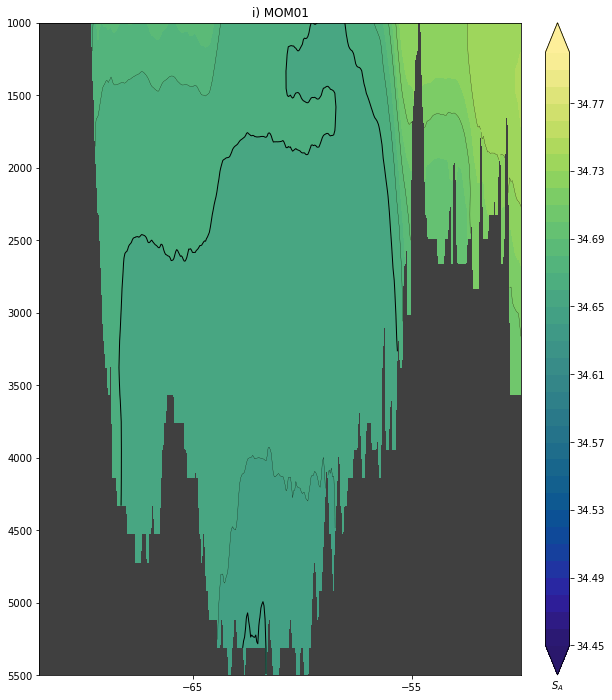

In [118]:
clev = np.arange(34.45,34.81,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34.45,34.82,.02)
#print clev3

plt.subplot(1,1,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=cm.cm.haline,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)

pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsbw_salt],colors='k',linewidths=1.0)
pr=plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=[wsdw_salt],colors='k',linewidths=1.0)

#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('i) MOM01')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical',ticks=[-1, 0, 1])
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)

[819] [1199] [-75.125] [19.875] [-55.13874852]
(50, 500)
(50, 500)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


KeyboardInterrupt: 

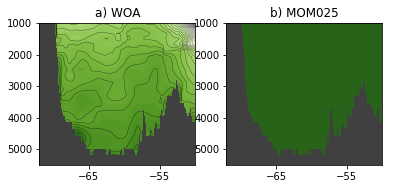

In [47]:
#plot control temp, rho, salt at 0W
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

#var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)
var1= np.squeeze(woa_rho[:,0:500,x2])
print var1.shape

clev = np.arange(27.65,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.65,27.9,.005)
#print clev3

plt.subplot(4,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('a) WOA')

yr=0

#var1=np.squeeze(np_cntrl.pot_rho_0[0:9,:,0:500,x2].mean('time').load())
var1=np_cntrl_rho2

print var1.shape

plt.subplot(4,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('b) MOM025')

t1=3
t2=7
var1=np.squeeze(mom01_cntrl.pot_rho_0[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('c) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$kg/m^3$')


clev = np.arange(-1.5,2.5,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-1.5,2.5,.1)
#print clev3

var1=np.squeeze(woa_temp[:,0:500,x2])

plt.subplot(4,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('d) WOA')

yr=0

var1=np.squeeze(np_cntrl.temp[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('e) MOM025')

t1=3
t2=7
var1=np.squeeze(mom01_cntrl.temp[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('f) MOM01')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34.45,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34.45,34.8,.02)
#print clev3

var1=np.squeeze(woa_salt[:,0:500,x2])

plt.subplot(4,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('g) WOA')

yr=0

var1=np.squeeze(np_cntrl.salt[0:9,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('h) MOM025')

t1=3
t2=7
var1=np.squeeze(mom01_cntrl.salt[t1:t2,:,0:1000,mom01_x2].mean('time').load())

plt.subplot(4,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(mom01_yt_ocean[0:1000],mom01_st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('i) MOM01')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)


clev = np.arange(180,270,1)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(180,270,10)
print clev3

#var1=np.nanmean(woa1_oxy[:,0:90,woa1_x1:woa1_x2],axis=2)*1000
var1=np.squeeze(woa2_oxy[0,:,0:90,woa2_x2])
print var1.shape

plt.subplot(4,3,10)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(woa1_lat[0:90],woa1_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contour(woa1_lat[0:90],woa1_depth,var1,levels=clev3,colors='k',linewidths=0.25)
p1=plt.contourf(woa2_lat[0:90],woa2_depth,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(woa2_lat[0:90],woa2_depth,var1,levels=clev3,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('j) WOA')

yr=0

var1=np.squeeze(np_cntrl_bgc.o2[0:12,:,0:500,x2].mean('time').load())
print var1.shape

plt.subplot(4,3,11)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$S)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.ylim((5500,1000))
plt.xlim([-72,-50])
plt.xticks([-65,-55])
plt.title('k) MOM025')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
cb=plt.colorbar(p1,cax,orientation='vertical')
cb.ax.set_xlabel('      $\mu mol/m^3$')

plt.tight_layout()

#of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig1_TS_02_WOA_0W_all.png'
#plt.savefig(of,dpi=220)

